In [76]:
#from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [100]:
X, y = make_blobs(n_samples=100, centers=2, n_features=4, random_state=0)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80, 4) (20, 4) (80,) (20,)


In [102]:
x1_train = [X_train[i] for i in range(len(X_train)) if y[i] == 0]
x2_train = [X_train[i] for i in range(len(X_train)) if y[i] == 1]

x1_train = np.array(x1_train)
x2_train = np.array(x2_train)

In [103]:
x1_test = [X_test[i] for i in range(len(X_test)) if y[i] == 0]
x2_test = [X_test[i] for i in range(len(X_test)) if y[i] == 1]

x1_test = np.array(x1_test)
x2_test = np.array(x2_test)

In [104]:
# size of training data set
training_size = 400
# dimension of data sets
n = 2
training_input = {'A':x1_train, 'B':x2_train}
test_input = {'A':x1_test, 'B':x2_test}
class_labels = ['A', 'B']
sv = Statevector.from_label('0' * n)

In [105]:
def final_circuit(circuit, data, params):
    for i in range(n):
        circuit.h(i)
        circuit.rz(data[i],i)
        circuit.ry(data[i+2],i)
        circuit.ry(params[i], i)
    circuit.cx(0,1)

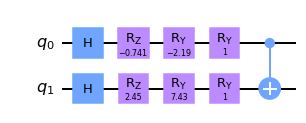

In [106]:
cir = QuantumCircuit(2)
final_circuit(cir, x1_train[0],[1,1])
cir.draw('mpl')

In [107]:
from typing import Optional, Callable, Tuple, List
import os
import numpy as np
import csv
from qiskit.aqua import aqua_globals
from qiskit.aqua.components.optimizers import Optimizer, OptimizerSupportLevel


class ADAM(Optimizer):
    """Adam and AMSGRAD optimizers.
        This implementation is taken directly from Qiskit. Please see Qiskit optimiser documentation for details.
        """

    _OPTIONS = ['maxiter', 'tol', 'lr', 'beta_1', 'beta_2',
                'noise_factor', 'eps', 'amsgrad', 'snapshot_dir']

    def __init__(self,
                 maxiter: int = 10000,
                 tol: float = 1e-6,
                 lr: float = 1e-3,
                 beta_1: float = 0.9,
                 beta_2: float = 0.99,
                 noise_factor: float = 1e-8,
                 eps: float = 1e-10,
                 amsgrad: bool = False,
                 snapshot_dir: Optional[str] = None) -> None:

        super().__init__()
        for k, v in locals().items():
            if k in self._OPTIONS:
                self._options[k] = v
        self._maxiter = maxiter
        self._snapshot_dir = snapshot_dir
        self._tol = tol
        self._lr = lr
        self._beta_1 = beta_1
        self._beta_2 = beta_2
        self._noise_factor = noise_factor
        self._eps = eps
        self._amsgrad = amsgrad
        self.loss_list = []
        self.params = []
        # runtime variables
        self._t = 0  # time steps
        self._m = np.zeros(1)
        self._v = np.zeros(1)
        if self._amsgrad:
            self._v_eff = np.zeros(1)

        if self._snapshot_dir:

            with open(os.path.join(self._snapshot_dir, 'adam_params.csv'), mode='w') as csv_file:
                if self._amsgrad:
                    fieldnames = ['v', 'v_eff', 'm', 't']
                else:
                    fieldnames = ['v', 'm', 't']
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writeheader()

    def get_support_level(self):
        """ Return support level dictionary """
        return {
            'gradient': OptimizerSupportLevel.supported,
            'bounds': OptimizerSupportLevel.ignored,
            'initial_point': OptimizerSupportLevel.supported
        }

    def save_params(self, snapshot_dir: str) -> None:
        if self._amsgrad:
            with open(os.path.join(snapshot_dir, 'adam_params.csv'), mode='a') as csv_file:
                fieldnames = ['v', 'v_eff', 'm', 't']
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writerow({'v': self._v, 'v_eff': self._v_eff,
                                 'm': self._m, 't': self._t})
        else:
            with open(os.path.join(snapshot_dir, 'adam_params.csv'), mode='a') as csv_file:
                fieldnames = ['v', 'm', 't']
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writerow({'v': self._v, 'm': self._m, 't': self._t})

    def load_params(self, load_dir: str) -> None:

        with open(os.path.join(load_dir, 'adam_params.csv'), mode='r') as csv_file:
            if self._amsgrad:
                fieldnames = ['v', 'v_eff', 'm', 't']
            else:
                fieldnames = ['v', 'm', 't']
            reader = csv.DictReader(csv_file, fieldnames=fieldnames)
            for line in reader:
                v = line['v']
                if self._amsgrad:
                    v_eff = line['v_eff']
                m = line['m']
                t = line['t']

        v = v[1:-1]
        self._v = np.fromstring(v, dtype=float, sep=' ')
        if self._amsgrad:
            v_eff = v_eff[1:-1]
            self._v_eff = np.fromstring(v_eff, dtype=float, sep=' ')
        m = m[1:-1]
        self._m = np.fromstring(m, dtype=float, sep=' ')
        t = t[1:-1]
        self._t = np.fromstring(t, dtype=int, sep=' ')

    def minimize(self, objective_function: Callable[[np.ndarray], float], initial_point: np.ndarray,
                 gradient_function: Callable[[np.ndarray], float]) -> Tuple[np.ndarray, float, int]:

        derivative = gradient_function(initial_point)
        self._t = 0
        self._m = np.zeros(np.shape(derivative))
        self._v = np.zeros(np.shape(derivative))
        if self._amsgrad:
            self._v_eff = np.zeros(np.shape(derivative))
        self.loss_list = []
        self.params = []
        params = params_new = initial_point
        while self._t < self._maxiter:
            derivative = gradient_function(params)
            self._t += 1
            self._m = self._beta_1 * self._m + (1 - self._beta_1) * derivative
            self._v = self._beta_2 * self._v + (1 - self._beta_2) * derivative * derivative
            lr_eff = self._lr * np.sqrt(1 - self._beta_2 ** self._t) / (1 - self._beta_1 ** self._t)
            if not self._amsgrad:
                params_new = (params - lr_eff * self._m.flatten()
                              / (np.sqrt(self._v.flatten()) + self._noise_factor))
                self.params.append(params_new)
                self.loss_list.append(objective_function(params_new))
            else:
                self._v_eff = np.maximum(self._v_eff, self._v)
                params_new = (params - lr_eff * self._m.flatten()
                              / (np.sqrt(self._v_eff.flatten()) + self._noise_factor))
                self.params.append(params_new)
                self.loss_list.append(objective_function(params_new))
            if self._snapshot_dir:
                self.save_params(self._snapshot_dir)
            if np.linalg.norm(params - params_new) < self._tol:
                return params_new, objective_function(params_new), self._t
            else:
                params = params_new
        return params_new, objective_function(params_new), self._t

    def optimize(self, num_vars: int, objective_function: Callable[[np.ndarray], float],
                 gradient_function: Optional[Callable[[np.ndarray], float]] = None,
                 variable_bounds: Optional[List[Tuple[float, float]]] = None,
                 initial_point: Optional[np.ndarray] = None
                 ) -> Tuple[np.ndarray, float, int]:

        super().optimize(num_vars, objective_function, gradient_function,
                         variable_bounds, initial_point)
        if initial_point is None:
            initial_point = aqua_globals.random.random(num_vars)
        if gradient_function is None:
            gradient_function = Optimizer.wrap_function(Optimizer.gradient_num_diff,
                                                        (objective_function, self._eps))

        point, value, nfev = self.minimize(objective_function, initial_point, gradient_function)
        return point, value, nfev, self.loss_list, self.params

In [108]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)
    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 2  # num of trainable params
for i in range(1):
    np.random.seed(i)
    init_params = np.random.uniform(-1,1,d)
    print(init_params)
    # train classifier
    opt_params, value, _, loss, params = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Data/1Layer/Layer1Easy/quantum_loss_easy_layer1blobs500_%d.npy' %i
    f2 = 'Data/1Layer/Layer1Easy/opt_params_easy_layer1blobs500_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

[0.09762701 0.43037873]
[1.036777808384636, 0.9991663764436144, 0.9691712582796506, 0.9461353430909476, 0.9292862096889817, 0.9180267471637199, 0.9118799817247274, 0.9103725665090538, 0.9129191933421488, 0.9186169746530789, 0.925740118080958, 0.9313812654232276, 0.9329731115498312, 0.9304010862270214, 0.9254434631405852, 0.920143503938658, 0.9157333151179209, 0.9126557401487447, 0.9109186789928998, 0.9103300183122863, 0.910611890924169, 0.9114582307210789, 0.9125715003412326, 0.9136905325577216, 0.9146110602941295, 0.9151978191055805, 0.9153877849849208, 0.9151849036010358, 0.9146481674811431, 0.9138754971150889, 0.9129856077959093, 0.9121001497840817, 0.9113276670737627, 0.9107503029638698, 0.910414385192607, 0.9103253634159524, 0.9104482036931592, 0.910714120476633, 0.911034023078547, 0.9113173503455814, 0.9114924894083716, 0.9115225503404641, 0.9114110074351265, 0.91119525895425, 0.9109315761092851, 0.9106777143413092, 0.9104788127065888, 0.9103597353459442, 0.9103238482617904, 0.91

In [12]:
opt_params = np.load('Data/1Layer/Layer1Easy/opt_params_easy_layer1blobs1000_0.npy')

In [13]:
opt_params

array([0.91281157, 0.41852155])

In [114]:
def cost_function_test(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in test_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    return cost

In [115]:
test_loss = []
for i in range(len(params)):
    test_loss.append(cost_function_test(test_input, class_labels, params[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [111]:
len(test_loss)

100

In [112]:
test_loss

[0.7248357603254606,
 0.7223480898761739,
 0.7231469363325698,
 0.7269850562717818,
 0.7327072068307012,
 0.738306058592852,
 0.7418617416644063,
 0.7429134228533079,
 0.7425312547292274,
 0.7420002761213331,
 0.7418727081263935,
 0.7420001957295153,
 0.7420598581720916,
 0.7419680488222999,
 0.7418704351542178,
 0.7419349427199181,
 0.7422030319742814,
 0.7425699720979326,
 0.7428544524392995,
 0.742897301102705,
 0.7426345893129752,
 0.7421128622812381,
 0.741452772358621,
 0.7407946940354638,
 0.740256838894143,
 0.7399161285885544,
 0.739806236593242,
 0.7399236077007211,
 0.7402352383277708,
 0.740686336304797,
 0.7412087678720138,
 0.7417312708582141,
 0.7421911211949832,
 0.7425449940615663,
 0.7427753668893433,
 0.7428901513713909,
 0.7429157216933404,
 0.7428865061483738,
 0.7428352749521672,
 0.742787052803912,
 0.7427571613791397,
 0.742752052130182,
 0.7427710474088094,
 0.7428079218556107,
 0.7428523339021543,
 0.7428917353073384,
 0.7429141188051489,
 0.7429111307423205,


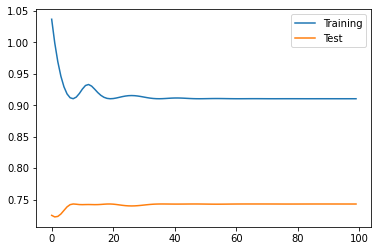

In [116]:
plt.plot(range(100), loss)
plt.plot(range(100), test_loss)

legendList = ['{}'.format(i) for i in ["Training", "Test","3 Layers","4 Layers"]]
plt.legend(legendList)


In [42]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Data/1Layer/Layer1Easy/quantum_loss_easy_layer1blobs_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [43]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 1 Layer (Data Reuploading, Qubits = 2, Easy Model, Blobs)')

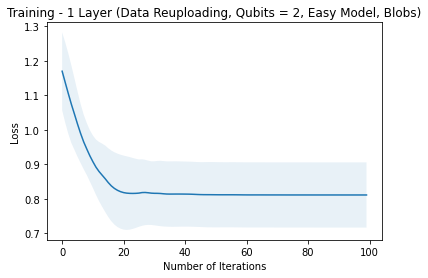

In [44]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 1 Layer (Data Reuploading, Qubits = 2, Easy Model, Blobs)")